In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import shap
import joblib
import json


# Load dataset

from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/ChronicKidneyDisease_EHRs_from_AbuDhabi.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Sex,AgeBaseline,HistoryDiabetes,HistoryCHD,HistoryVascular,HistorySmoking,HistoryHTN,HistoryDLD,HistoryObesity,DLDmeds,...,ACEIARB,CholesterolBaseline,CreatinineBaseline,eGFRBaseline,sBPBaseline,dBPBaseline,BMIBaseline,TimeToEventMonths,EventCKD35,TIME_YEAR
0,0,64,0,0,0,0,1,1,1,1,...,0,4.8,59.0,93.3,144,87,40,98,0,8
1,0,52,0,0,0,0,1,1,1,0,...,0,6.4,52.0,105.8,148,91,45,106,0,9
2,0,56,0,0,0,0,1,1,1,1,...,0,6.4,57.0,99.8,149,86,41,88,0,7
3,0,58,0,0,0,0,0,1,1,1,...,0,5.1,65.0,90.3,116,68,32,103,0,9
4,0,63,1,0,0,0,1,1,1,1,...,1,5.0,70.0,79.7,132,63,31,105,0,9


In [ ]:
# Separate numeric and binary features

def split_features(df, target_column):
    numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target_column]
    # Check for binary columns (0 or 1)
    binary_cols = [c for c in numeric_cols if df[c].dropna().isin([0,1]).all()]
    numeric_cols_clean = [c for c in numeric_cols if c not in binary_cols]
    return numeric_cols_clean, binary_cols

num_features, binary_features = split_features(df, 'EventCKD35')
cat_features = [c for c in binary_features if c != 'EventCKD35']


# EDA

print("Dataset shape:", df.shape)
print(df.describe())

Dataset shape: (491, 22)
              Sex  AgeBaseline  HistoryDiabetes  HistoryCHD  HistoryVascular  \
count  491.000000   491.000000       491.000000  491.000000       491.000000   
mean     0.509165    53.203666         0.437882    0.091650         0.059063   
std      0.500426    13.821282         0.496632    0.288825         0.235983   
min      0.000000    23.000000         0.000000    0.000000         0.000000   
25%      0.000000    44.000000         0.000000    0.000000         0.000000   
50%      1.000000    54.000000         0.000000    0.000000         0.000000   
75%      1.000000    64.000000         1.000000    0.000000         0.000000   
max      1.000000    89.000000         1.000000    1.000000         1.000000   

       HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity     DLDmeds  \
count      491.000000   491.000000  491.000000      491.000000  491.000000   
mean         0.152749     0.682281    0.645621        0.505092    0.551935   
std          0.36011

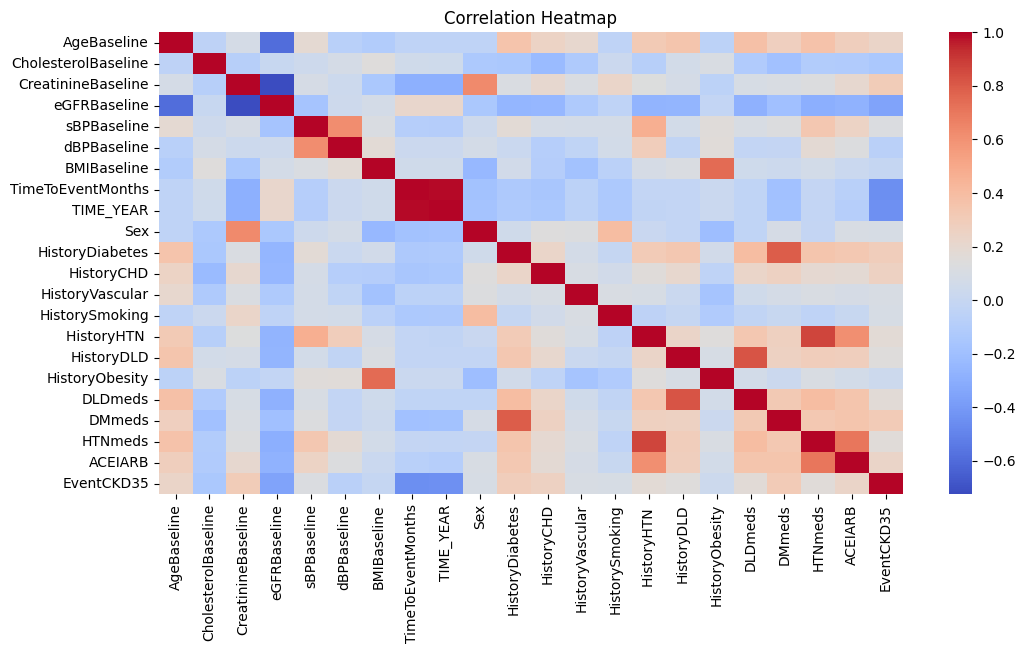

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df[num_features + cat_features + ['EventCKD35']].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig("correlation.png", dpi=300, bbox_inches='tight')
plt.show()

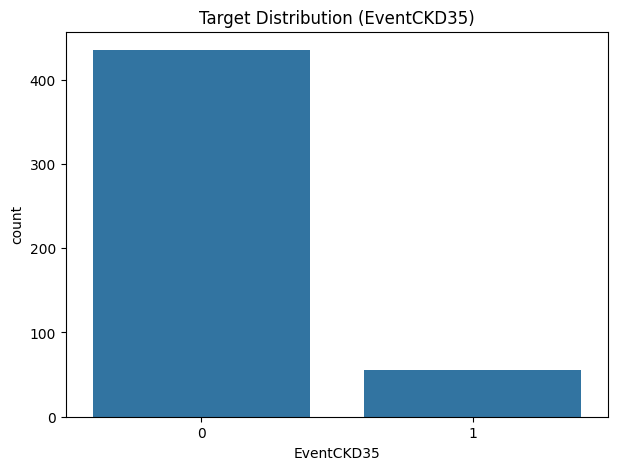

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='EventCKD35')
plt.title("Target Distribution (EventCKD35)")
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Filter dataset
filtered_df = df.dropna(subset=num_features + cat_features+binary_features)

# Demographics

fig_sex = px.pie(filtered_df, names='Sex', title='Sex Distribution')
fig_sex.show()

In [ ]:
fig_age = px.histogram(filtered_df, x='AgeBaseline', nbins=20, title='Age Distribution')
fig_age.show()

In [ ]:
# Disease History Prevalence

diseases = ['HistoryDiabetes','HistoryCHD','HistoryVascular','HistorySmoking'
            ,'HistoryDLD','HistoryObesity']

disease_df = filtered_df[diseases].mean().reset_index()
disease_df.columns = ['Disease', 'Prevalence']

fig_disease = px.bar(disease_df, x='Disease', y='Prevalence', title='Prevalence of Risk Factors')
fig_disease.show()

In [ ]:
# Lab Feature Correlation Heatmap

labs = ['CholesterolBaseline','CreatinineBaseline','eGFRBaseline','sBPBaseline','dBPBaseline','BMIBaseline']
corr_matrix = filtered_df[labs].corr()

fig_corr = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,

    zmin=-1, zmax=1
))
fig_corr.update_layout(title="Correlation Heatmap of Lab Features")
fig_corr.show()

In [ ]:
# CKD Event Distribution

fig_event = px.box(filtered_df, x='EventCKD35', y='TimeToEventMonths',
                   title='Time to CKD Event by Outcome', points='all')
fig_event.show()

In [ ]:
# Medication

meds = ['DLDmeds', 'ACEIARB']
med_df = filtered_df[meds].mean().reset_index()
med_df.columns = ['Medication', 'Proportion']

fig_med = px.bar(med_df, x='Medication', y='Proportion', title='Proportion of Patients on Medications')
fig_med.show()

In [ ]:
# Pairplot for features

selected_features = labs
fig_pair = px.scatter_matrix(filtered_df, dimensions=selected_features, color='EventCKD35',
                             title='Pairplot of Lab Features by CKD Event')
fig_pair.show()

In [ ]:
# Prepare modeling

X = df.drop(columns=['EventCKD35'])
y = df['EventCKD35']

preprocess = ColumnTransformer([
    ('num',
     Pipeline([('imputer',
                SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_features),
    ('cat', Pipeline([('imputer',
                       SimpleImputer(strategy='most_frequent'))]), cat_features)
], remainder='passthrough')

In [ ]:
# Define models

models = {
    'LogisticRegression': Pipeline([('prep', preprocess), ('clf', LogisticRegression(max_iter=1000, random_state=42))]),
    'RandomForest': Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),
    'XGBoost': Pipeline([('prep', preprocess), ('clf', XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42))]),
    'MLP': Pipeline([('prep', preprocess), ('clf', MLPClassifier(hidden_layer_sizes=(60,30), max_iter=500, random_state=42))])
}


# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Train models and store results

results_list = []
# Store probabilities for the best model for ROC plotting later
best_model_proba = None

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]

    auc_score = roc_auc_score(y_test, proba) # Calculate AUC

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, pred),
        'precision': precision_score(y_test, pred, zero_division=0),
        'recall': recall_score(y_test, pred, zero_division=0),
        'f1': f1_score(y_test, pred, zero_division=0),
        'auc': auc_score
    }
    results_list.append(metrics)

results_df = pd.DataFrame(results_list)
print("\nModel Evaluation Results:")
print(results_df)

Training LogisticRegression...
Training RandomForest...
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[22:08:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Training MLP...

Model Evaluation Results:
                model  accuracy  precision    recall        f1       auc
0  LogisticRegression  0.929293   0.833333  0.454545  0.588235  0.943182
1        RandomForest  0.939394   1.000000  0.454545  0.625000  0.946281
2             XGBoost  0.949495   0.800000  0.727273  0.761905  0.964876
3                 MLP  0.959596   0.888889  0.727273  0.800000  0.975207


In [ ]:
best_model_row = results_df.sort_values('auc', ascending=False).iloc[0]
best_model_row.to_csv("ckd_model_metrics.csv", index=False)
best_model_name = best_model_row['model']
best_model = models[best_model_name]

# Retrieve probabilities for the best model now that it's selected
best_model_proba = best_model.predict_proba(X_test)[:,1]
best_model_auc = best_model_row['auc']

print(f"\nBest model selected: {best_model_name}")


Best model selected: MLP


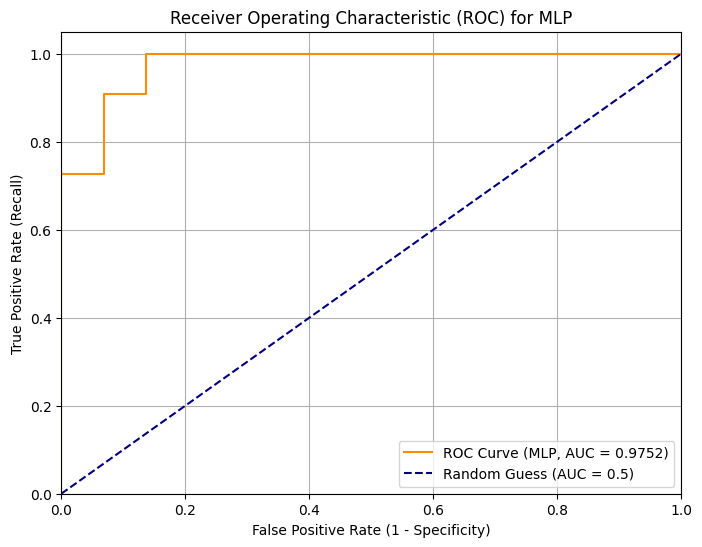

Saved ROC curve plot to roc_curve.png


In [ ]:
#  ROC CURVE PLOT
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, best_model_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve ({best_model_name}, AUC = {best_model_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'Receiver Operating Characteristic (ROC) for {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()
print("Saved ROC curve plot to roc_curve.png")

  0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

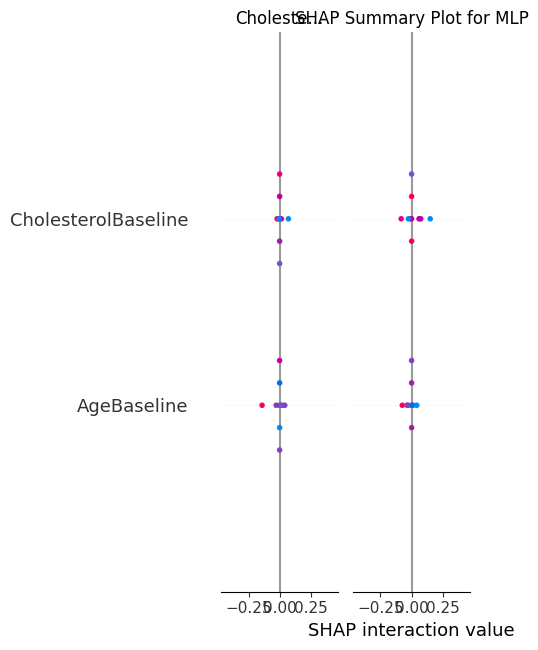

Saved MLP as best_model_pipeline.joblib


In [ ]:
# Interpretability for the best model

X_train_transformed = best_model.named_steps['prep'].transform(X_train)


TRANSFORMED_FEATURE_NAMES = num_features + cat_features


# SHAP Summary Plot
if best_model_name in ['RandomForest','XGBoost']:
    explainer = shap.TreeExplainer(best_model.named_steps['clf'])

    # Use a sample of the data for SHAP value calculation and plotting

    sample_size = min(500, X_train_transformed.shape[0])
    sample_indices = np.random.choice(X_train_transformed.shape[0], sample_size, replace=False)
    X_shap_sample = X_train_transformed[sample_indices]

    shap_values = explainer.shap_values(X_shap_sample)

    # The plotting data (X_shap_sample) and feature names list (TRANSFORMED_FEATURE_NAMES)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[1],
        X_shap_sample,
        feature_names=TRANSFORMED_FEATURE_NAMES,
        show=False
    )
    plt.title(f"SHAP Summary Plot for {best_model_name}")
    plt.tight_layout()
    plt.show()

else:
    # KernelExplainer for non-tree models
    X_explain = X_train_transformed[:10]
    explainer = shap.KernelExplainer(best_model.named_steps['clf'].predict_proba, X_train_transformed[:100])
    shap_values = explainer.shap_values(X_explain)

    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values_to_plot = shap_values[1]
    else:
        shap_values_to_plot = shap_values

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_to_plot,
        X_explain,
        feature_names=TRANSFORMED_FEATURE_NAMES,
        show=False
    )
    plt.title(f"SHAP Summary Plot for {best_model_name}")
    plt.tight_layout()
    plt.show()

# Save best model
# ----------------------------------------------
joblib.dump(best_model, "best_model_pipeline.joblib")
print(f"Saved {best_model_name} as best_model_pipeline.joblib")